In [57]:
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import date, datetime, timedelta
from collections import Counter
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
%matplotlib inline

from sklearn import linear_model as lm
from sklearn import ensemble as ens

from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import os

# the below import is from the functions defined in this project (found in the /src folder)
from src import functions as func

In [336]:
%load_ext autoreload
%autoreload 2

In [58]:
df = pd.read_csv('data/data_with_dummies_and_class.csv')

keep_cols = [x for x in df.columns if 'Unnamed' not in x]
df = df[keep_cols].set_index('ID')

## Reduce dataset 
* Remove unfair future predictors

In [281]:
dfl = df.drop(['usd pledged', 'pledged', 'usd_pledged_real', 'backers'], axis=1)

* Remove less useful datapoints

In [343]:
## drop catagory from axis (too many datapoints [159])
df_logis = dfl.drop([col for col in dfl.columns if col.split('&')[0] == 'category'], axis=1)

In [345]:
## for some reason there are still 2 n/a values, we will just remove these so the model will run
df_logis = df_logis.dropna()

* List regression ready dataset

In [340]:
func.get_feature_counts(df_logis).sort_values(ascending=False)

country                    22
main_category              15
currency                   14
launched_month             12
deadline_month             12
success                     1
name$word_count             1
name$verb_count             1
name$punc_count             1
name$preposition_count      1
name$possesive_count        1
name$noun_count             1
name$determinator_count     1
name$adj_count              1
length                      1
goal                        1
dtype: int64

In [342]:
func.get_feature_counts(df_logis).sum()

86

## Running Some Models

### Model with Kickstarter Name generated columns removed

0.694154982166
0.0176569770725


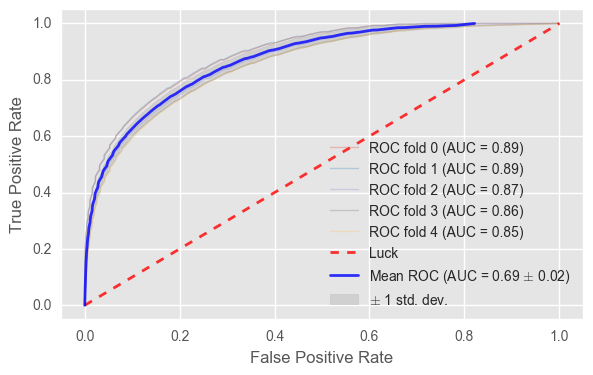

In [348]:
df_nonlp = df_logis[[col for col in df_logis.columns if '$' not in col]]

prob_folds, atcual = func.cv_build_model(df_nonlp, 'success', n_estimators=30)

tups = []
for pf, atc in zip(prob_folds, atcual):
    tups.append(func.find_auc(pf[:,1], atc))

func.plot_auc(tups)

### Model with Name generated Features included

0.862556448453
0.00986644019626


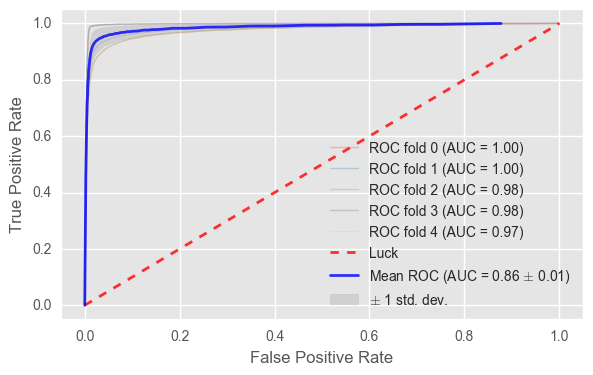

In [349]:
prob_folds, atcual = func.cv_build_model(df_logis, 'success', n_estimators=30)

tups = []
for pf, atc in zip(prob_folds, atcual):
    tups.append(func.find_auc(pf[:,1], atc))

func.plot_auc(tups);

### Check value of feature_imporatances characteristic

In [356]:
X = df_logis.copy()
y = X.pop('success')
classifier = ens.RandomForestClassifier(n_estimators=30,
                                        n_jobs=-1, 
                                        random_state=42) 
probs = classifier.fit(X, y).predict_proba(X)

In [357]:
pd.Series(classifier.feature_importances_, 
          index=df_logis.drop('success', axis=1).columns).sort_values(ascending=False).head(10)

goal                       0.213773
length                     0.119233
name$punc_count            0.112654
name$noun_count            0.077236
name$word_count            0.061901
name$adj_count             0.055833
name$verb_count            0.047730
name$preposition_count     0.040989
name$determinator_count    0.038741
main_category&Music        0.010138
dtype: float64

## Model excluding punctcuation count

0.780770936948
0.0120960438772


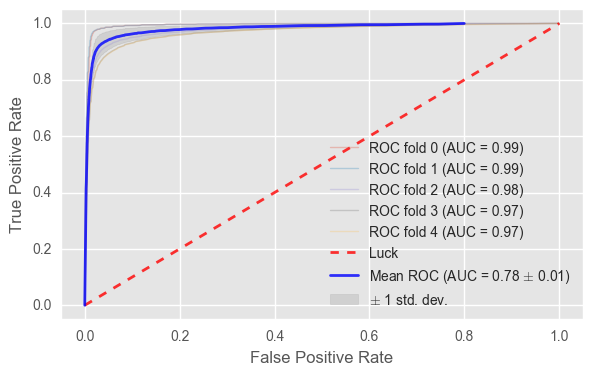

In [358]:
df_ = df_logis[[col for col in df_logis.columns if col != 'name$punc_count']]

prob_folds, atcual = func.cv_build_model(df_, 'success', n_estimators=30)

tups = []
for pf, atc in zip(prob_folds, atcual):
    tups.append(func.find_auc(pf[:,1], atc))

func.plot_auc(tups)

### Plot the Impact of n_estimators on model performance

In [359]:
def quick_fun(x):
    return cv_build_model(df_logis, 'success', n_estimators=x)

# aucs = pd.Series()
aucs = []
for i in [1, 2, 5, 10, 20, 30, 50, 80, 100]:
    ## Train model
    prob_folds, atcual = quick_fun(i)
    ## Identify Area under the ROC curve
    aucs.append(find_auc(prob_folds[0][:,1], atcual[0]))

(0.75, 1)

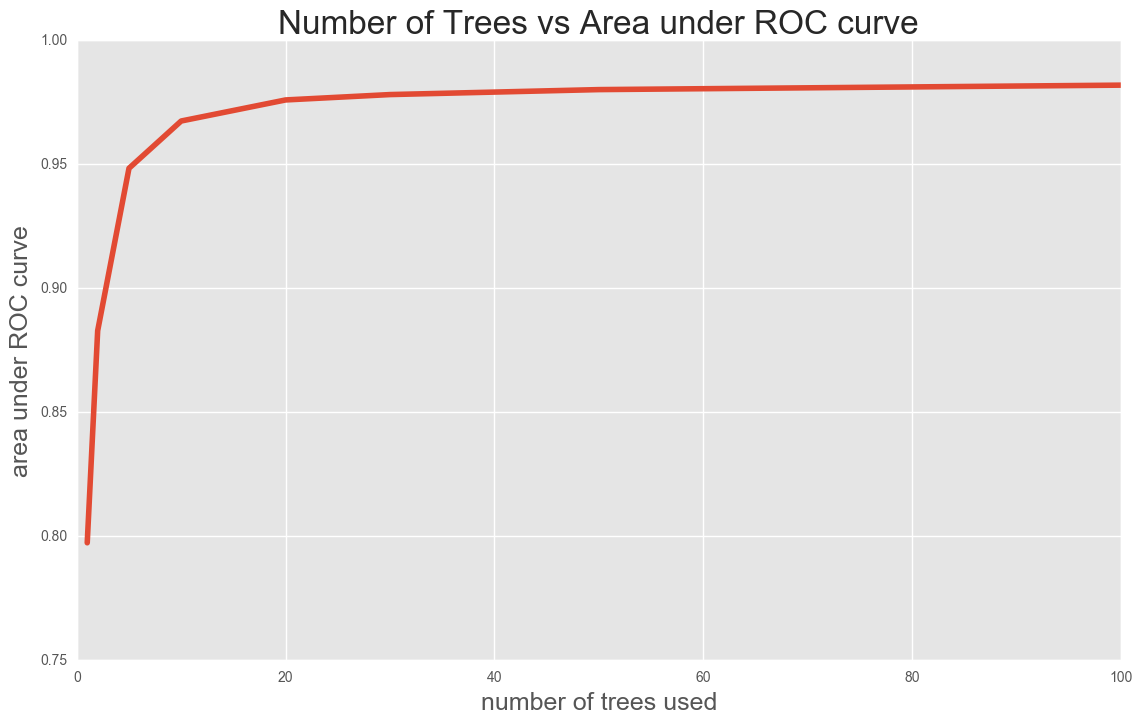

In [360]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(aucs_series)
ax.set_title('Number of Trees vs Area under ROC curve', fontdict={'size': 24})
ax.set_ylabel('area under ROC curve', fontdict={'size': 18})
ax.set_xlabel('number of trees used', fontdict={'size': 18})
ax.legend()
ax.set_ylim(.75,1)

### Check performance of Logistic Regression on same dataset

0.627440440737
0.00122216297518


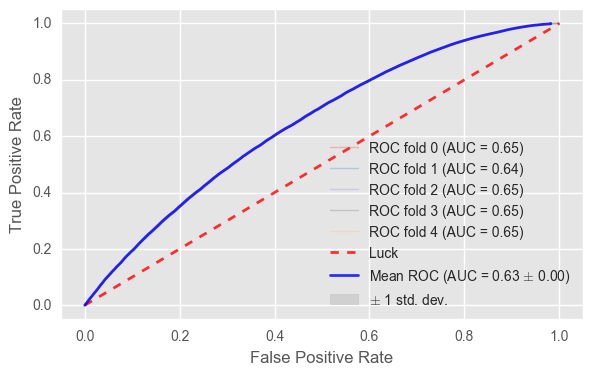

In [361]:
prob_folds, atcual = func.cv_build_model_logres(df_logis, 'success')

tups = []
for pf, atc in zip(prob_folds, atcual):
    tups.append(func.find_auc(pf[:,1], atc))

func.plot_auc(tups)

## Review Data Trends

In [257]:
def numeric_diffs(df, col):
    '''
    Return a tuple with the average value of a numeric
    column for passed and failed kickstarters 
        - passed mean value is idx0
    '''
    true = df[df['success'] == True][col].mean()
    false = df[df['success'] == False][col].mean()
    return true, false

def catagorical_diffs(df, col):
    '''
    Return The ratio of a specific catagory which are successful
    compared to the number of total observations in that catagory (float)
    '''
    df_sub = df[df[col] == 1]
    pos = df_sub[df_sub['success'] == True][col]
    return float(pos.shape[0]) / df_sub.shape[0]

In [245]:
## Identify diffirences in mean values for passed vs failed kickstarters 
##(and proportional diffirences)
for i in df_logis.columns:
    if '&' not in i:
        print i
        bb = numeric_diffs(df_logis, i)
        print "{} : {}".format(bb, np.abs((bb[0] - bb[1]) / bb[0]))

backers
(260.385614785961, 17.67219153682847) : 0.932130691815
goal
(9957.569297169925, 70380.18039338275) : 6.06800809444
name$word_count
(5.757171367428888, 5.3520766615091215) : 0.0703634962495
name$punc_count
(0.039817484433452545, 0.036480154279030154) : 0.0838156955897
name$caps_count
(0.22432375365304583, 0.2126587977349537) : 0.052000538187
name$possesive_count
(0.0008397914929335711, 0.0010343890743569584) : 0.231721305897
name$noun_count
(0.5667559793994963, 0.572412987684472) : 0.00998138262426
name$adj_count
(0.1272993990383299, 0.11844491430171178) : 0.0695563749987
name$verb_count
(0.09712414024310798, 0.11443331406689211) : 0.178217009494
name$preposition_count
(0.05958270190006616, 0.05548194528110008) : 0.0688246166789
name$determinator_count
(0.08286077356195674, 0.07288485483755043) : 0.120393743572
length
(32.325438617583174, 35.92310460220935) : 0.111295194698
success
(1.0, 0.0) : 1.0


In [ ]:
nseries = pd.Series()
for i in df_logis.columns:
    if '&' in i:
        bb = catagorical_diffs(df_logis, i)
        nseries[i] = bb

In [371]:
## Lowest proportion of successful catagories (in %)
nseries.sort_values(ascending=False).tail(15) * 100

currency&CHF                22.889610
country&DE                  22.086069
country&NO                  22.042139
currency&NOK                22.042139
currency&EUR                21.946271
main_category&Journalism    21.559737
currency&MXN                21.414039
country&MX                  21.414039
country&ES                  20.888158
country&NL                  20.557831
main_category&Technology    20.417242
country&AT                  18.377823
currency&JPY                17.500000
country&JP                  17.500000
country&IT                  15.190147
dtype: float64

In [372]:
## Highest proportion of successful catagories (in %)
nseries.sort_values(ascending=False).head(15) * 100

main_category&Dance           62.230317
main_category&Theater         60.139894
main_category&Comics          53.266537
main_category&Music           48.927171
main_category&Art             40.908044
deadline_month&Apr            38.435580
launched_month&Apr            38.435580
deadline_month&Mar            37.962478
launched_month&Mar            37.962478
launched_month&May            37.832687
deadline_month&May            37.832687
main_category&Film & Video    37.793793
country&US                    37.606100
currency&USD                  37.606100
deadline_month&Nov            37.355158
dtype: float64

In [373]:
data_og = pd.read_csv('data/data_nobadrows.csv').dropna()